# 1. Value Check

In [1]:
import pickle
import os

base_dir = "./OSTF/pks"
target_file = "anytext_test.pk"  # 원하는 파일 이름 하나만 지정

fpath = os.path.join(base_dir, target_file)
if not os.path.exists(fpath):
    print(f"파일 없음: {fpath}")
else:
    print(f"\n{target_file} 내용 확인")
    with open(fpath, 'rb') as f:
        data = pickle.load(f)

    print(f"타입: {type(data)}")
    if isinstance(data, dict):
        print(f"상위 키 개수: {len(data.keys())}")
        sample_keys = list(data.keys())
        if len(sample_keys) == 0:
            print("데이터가 비어있습니다.")
        else:
            first_key = sample_keys[0]
            print(f"첫 번째 키: {first_key}")

            first_val = data[first_key]
            print(f"{first_key} 값 타입: {type(first_val)}")

            if isinstance(first_val, dict):
                print(f"{first_key} 내부 키들: {list(first_val.keys())}")
                for k, v in first_val.items():
                    print(f"  {k}: {type(v)} → {str(v)}")
            else:
                print(f"{first_key} 값 예시: {first_val}")
    else:
        print(f"데이터 예시: {str(data)[:300]}")


anytext_test.pk 내용 확인
타입: <class 'dict'>
상위 키 개수: 233
첫 번째 키: mmacc/anytext/img_1.jpg
mmacc/anytext/img_1.jpg 값 타입: <class 'dict'>
mmacc/anytext/img_1.jpg 내부 키들: ['h', 'w', 'b']
  h: <class 'int'> → 1280
  w: <class 'int'> → 960
  b: <class 'numpy.ndarray'> → [[ 303  295  616  422    1]
 [ 517  919  830 1018    1]
 [ 172 1095  454 1208    1]
 [ 555 1092  724 1193    1]
 [  38   43  920  215    0]
 [   0  699   77  830    0]
 [ 128  705  483  839    0]
 [ 542  710  938  841    0]
 [  87  884  457 1021    0]]


# 2. Check each dataset's label ratio

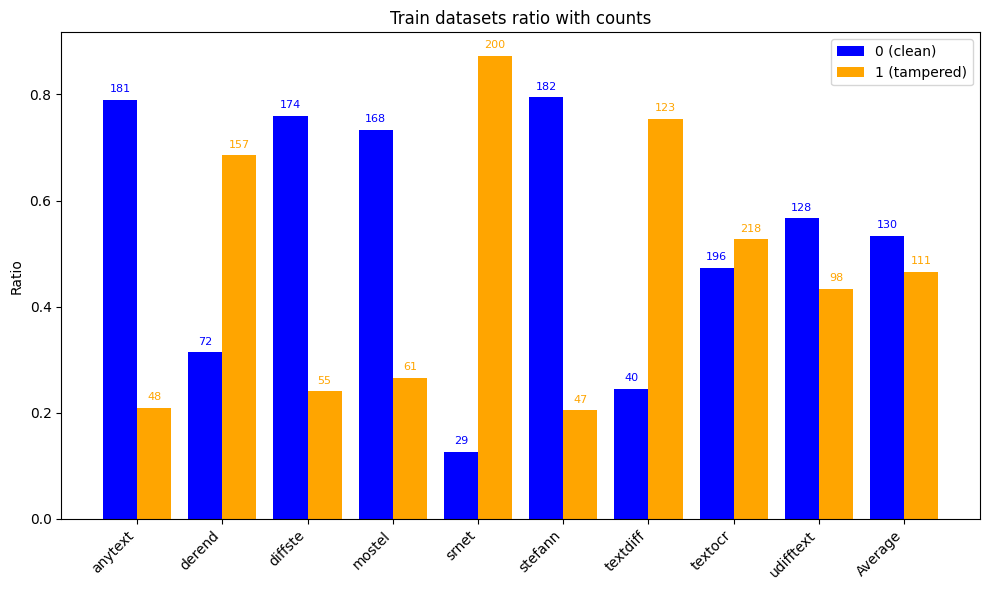

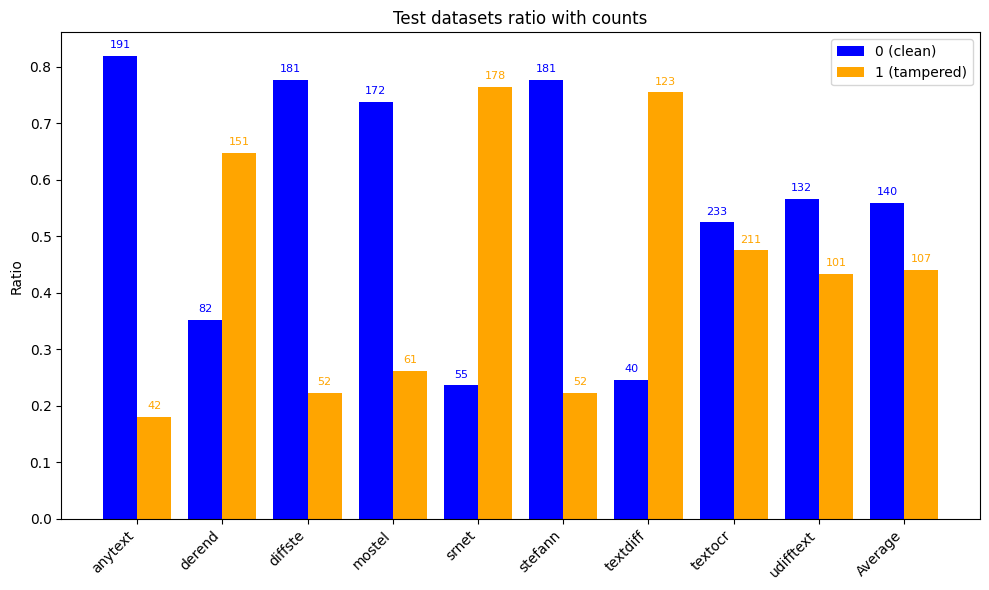

In [2]:
import os, pickle
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ===== 경로 =====
pks_dir = "./OSTF/pks"
pk_files = [
    "anytext_test.pk", "anytext_train.pk",
    "derend_test.pk", "derend_train.pk",
    "diffste_test.pk", "diffste_train.pk",
    "mostel_test.pk", "mostel_train.pk",
    "srnet_test.pk", "srnet_train.pk",
    "stefann_test.pk", "stefann_train.pk",
    "textdiff_test.pk", "textdiff_train.pk",
    "textocr_test.pk", "textocr_train.pk",
    "udifftext_test.pk", "udifftext_train.pk",
]

# ===== 데이터 수집 =====
train_labels_by_ds = defaultdict(list)
test_labels_by_ds = defaultdict(list)

for pk in pk_files:
    fpath = os.path.join(pks_dir, pk)
    if not os.path.exists(fpath):
        print(f"not found: {fpath}")
        continue

    ds_name = pk.split("_")[0]
    split_type = "train" if "_train" in pk else "test"

    with open(fpath, "rb") as f:
        data = pickle.load(f)

    for info in data.values():
        boxes = info.get("b", [])
        labels = [b[4] for b in boxes]
        img_label = 1 if any(l == 1 for l in labels) else 0

        if split_type == "train":
            train_labels_by_ds[ds_name].append(img_label)
        else:
            test_labels_by_ds[ds_name].append(img_label)

# ===== 비율/개수 계산 =====
def compute_ratios_and_counts(label_dict):
    ds_names = list(label_dict.keys())
    zero_ratios, one_ratios = [], []
    zero_counts, one_counts = [], []
    for ds in ds_names:
        labels = label_dict[ds]
        c = Counter(labels)
        total = sum(c.values())
        zero_counts.append(c.get(0, 0))
        one_counts.append(c.get(1, 0))
        zero_ratios.append(c.get(0, 0) / total if total > 0 else 0)
        one_ratios.append(c.get(1, 0) / total if total > 0 else 0)
    # 평균 추가
    if ds_names:
        avg_zero_ratio = sum(zero_ratios) / len(zero_ratios)
        avg_one_ratio = sum(one_ratios) / len(one_ratios)
        avg_zero_count = sum(zero_counts) // len(zero_counts) if zero_counts else 0
        avg_one_count = sum(one_counts) // len(one_counts) if one_counts else 0
        ds_names.append("Average")
        zero_ratios.append(avg_zero_ratio)
        one_ratios.append(avg_one_ratio)
        zero_counts.append(avg_zero_count)
        one_counts.append(avg_one_count)
    return ds_names, zero_ratios, one_ratios, zero_counts, one_counts

# ===== 시각화 함수 =====
def plot_grouped(ds_names, zero_ratios, one_ratios, zero_counts, one_counts, title):
    x = range(len(ds_names))
    bar_width = 0.4
    plt.figure(figsize=(max(10, len(ds_names)), 6))

    bars0 = plt.bar([i-bar_width/2 for i in x], zero_ratios, width=bar_width, color='blue', label='0 (clean)')
    bars1 = plt.bar([i+bar_width/2 for i in x], one_ratios, width=bar_width, color='orange', label='1 (tampered)')

    # 막대 위에 개수 표기
    for i, bar in enumerate(bars0):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{zero_counts[i]}", ha='center', va='bottom', fontsize=8, color='blue')
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{one_counts[i]}", ha='center', va='bottom', fontsize=8, color='orange')

    plt.xticks(x, ds_names, rotation=45, ha='right')
    plt.ylabel("Ratio")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== 실행 =====
train_ds, train_zero_ratio, train_one_ratio, train_zero_cnt, train_one_cnt = compute_ratios_and_counts(train_labels_by_ds)
plot_grouped(train_ds, train_zero_ratio, train_one_ratio, train_zero_cnt, train_one_cnt, "Train datasets ratio with counts")

test_ds, test_zero_ratio, test_one_ratio, test_zero_cnt, test_one_cnt = compute_ratios_and_counts(test_labels_by_ds)
plot_grouped(test_ds, test_zero_ratio, test_one_ratio, test_zero_cnt, test_one_cnt, "Test datasets ratio with counts")

# 3. Check each dataset's label ratio after make OCR

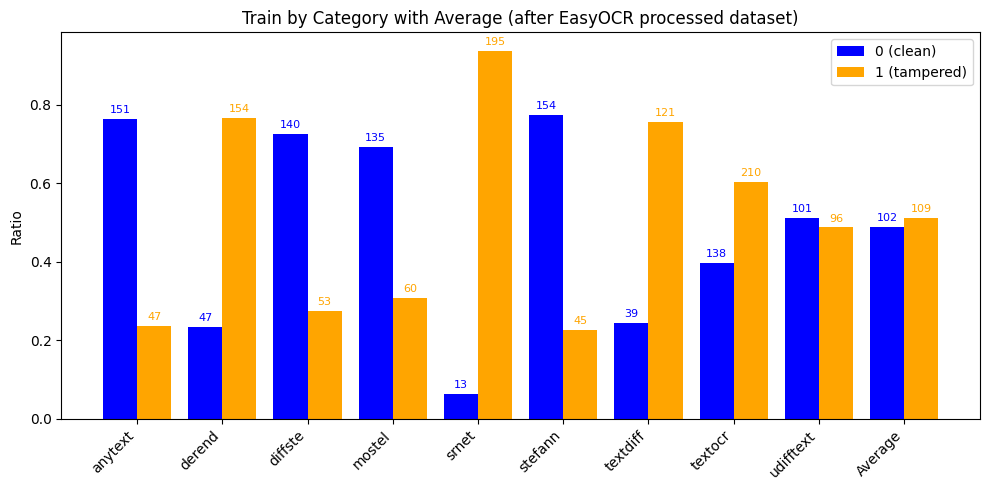

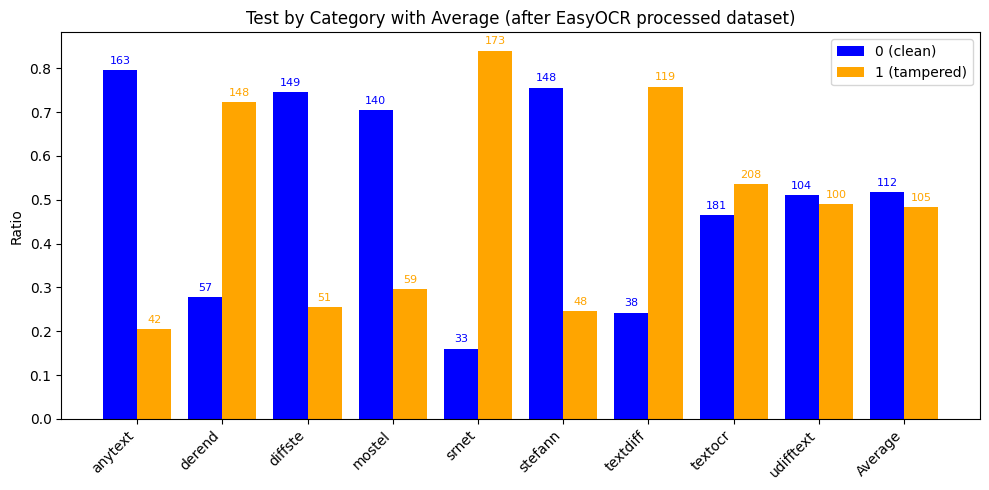

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter, defaultdict

# ===== 경로 =====
output_dir = "./OSTF/output/"
train_csv = os.path.join(output_dir, "train.csv")
test_csv  = os.path.join(output_dir, "test.csv")

# ===== 범주 추출 함수 =====
def extract_category(txt_path: str) -> str:
    part = txt_path.split("txt/")[-1]
    category = part.split("/")[0]
    category = category.replace("_train", "").replace("_test", "")
    return category

# ===== 범주별 비율/개수 계산 및 플롯 =====
def plot_category_distribution(csv_path, title):
    if not os.path.exists(csv_path):
        print(f"{csv_path} not found")
        return
    df = pd.read_csv(csv_path)
    if "txt_path" not in df.columns or "label" not in df.columns:
        print(f"missing 'txt_path' or 'label' in {csv_path}")
        return

    # 범주 추출
    df["category"] = df["txt_path"].apply(extract_category)

    # 범주별 집계
    category_labels = defaultdict(list)
    for _, row in df.iterrows():
        category_labels[row["category"]].append(row["label"])

    ds_names = list(category_labels.keys())
    zero_ratios, one_ratios = [], []
    zero_counts, one_counts = [], []

    for ds in ds_names:
        labels = category_labels[ds]
        c = Counter(labels)
        total = c[0] + c[1]
        zero_counts.append(c.get(0,0))
        one_counts.append(c.get(1,0))
        zero_ratios.append(c.get(0,0)/total if total>0 else 0)
        one_ratios.append(c.get(1,0)/total if total>0 else 0)

    # 평균 추가
    if ds_names:
        avg_zero_ratio = sum(zero_ratios)/len(zero_ratios)
        avg_one_ratio = sum(one_ratios)/len(one_ratios)
        avg_zero_count = sum(zero_counts)//len(zero_counts) if zero_counts else 0
        avg_one_count = sum(one_counts)//len(one_counts) if one_counts else 0
        ds_names.append("Average")
        zero_ratios.append(avg_zero_ratio)
        one_ratios.append(avg_one_ratio)
        zero_counts.append(avg_zero_count)
        one_counts.append(avg_one_count)

    # 플롯
    x = range(len(ds_names))
    bar_width = 0.4
    plt.figure(figsize=(max(10,len(ds_names)),5))
    bars0 = plt.bar([i-bar_width/2 for i in x], zero_ratios, width=bar_width, color='blue', label='0 (clean)')
    bars1 = plt.bar([i+bar_width/2 for i in x], one_ratios, width=bar_width, color='orange', label='1 (tampered)')

    # 개수 표기
    for i, bar in enumerate(bars0):
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height+0.01, f"{zero_counts[i]}", ha='center', va='bottom', fontsize=8, color='blue')
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height+0.01, f"{one_counts[i]}", ha='center', va='bottom', fontsize=8, color='orange')

    plt.xticks(x, ds_names, rotation=45, ha='right')
    plt.ylabel("Ratio")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== 실행 =====
plot_category_distribution(train_csv, "Train by Category with Average (after EasyOCR processed dataset)")
plot_category_distribution(test_csv,  "Test by Category with Average (after EasyOCR processed dataset)")

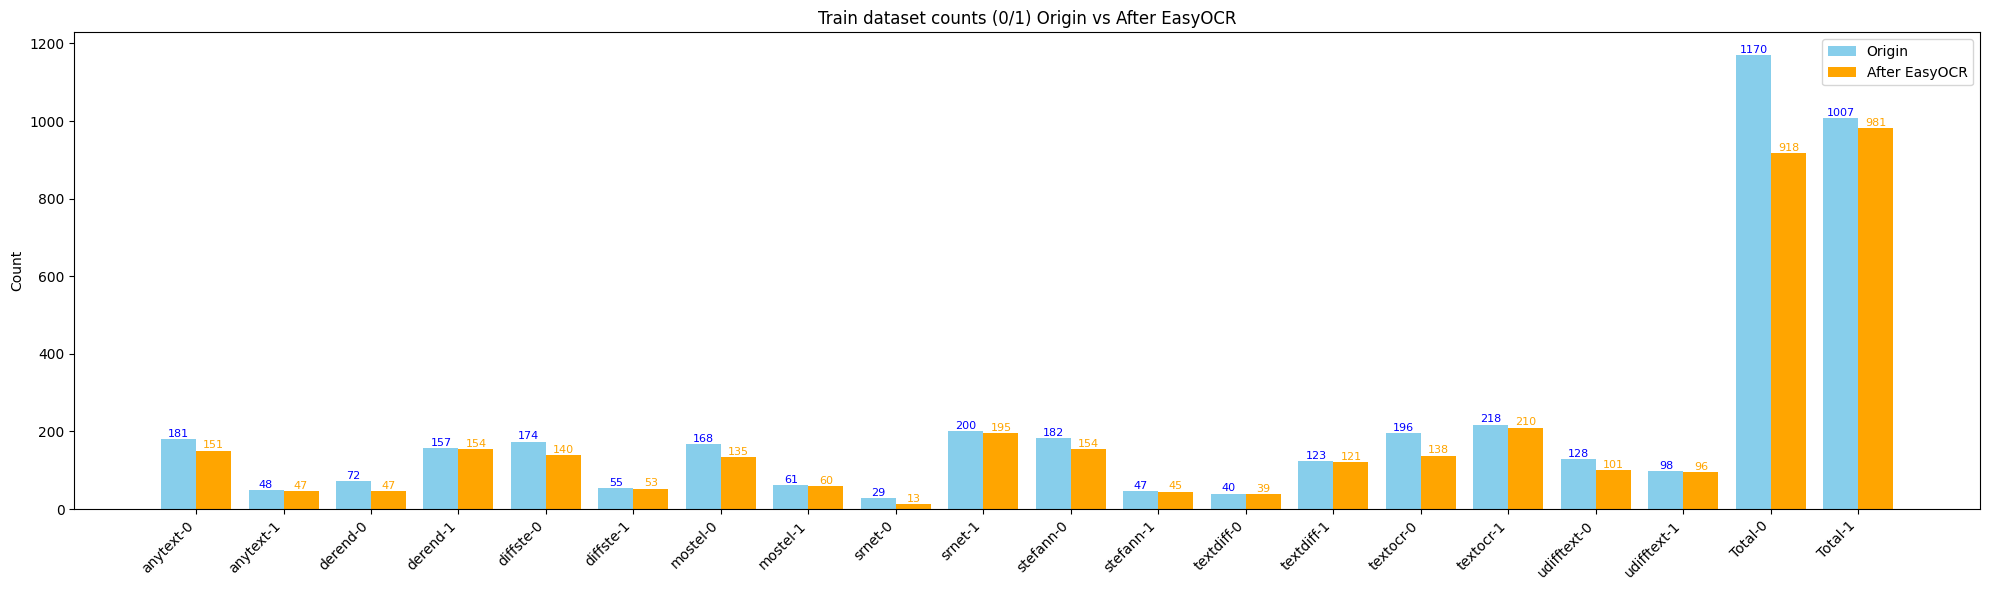

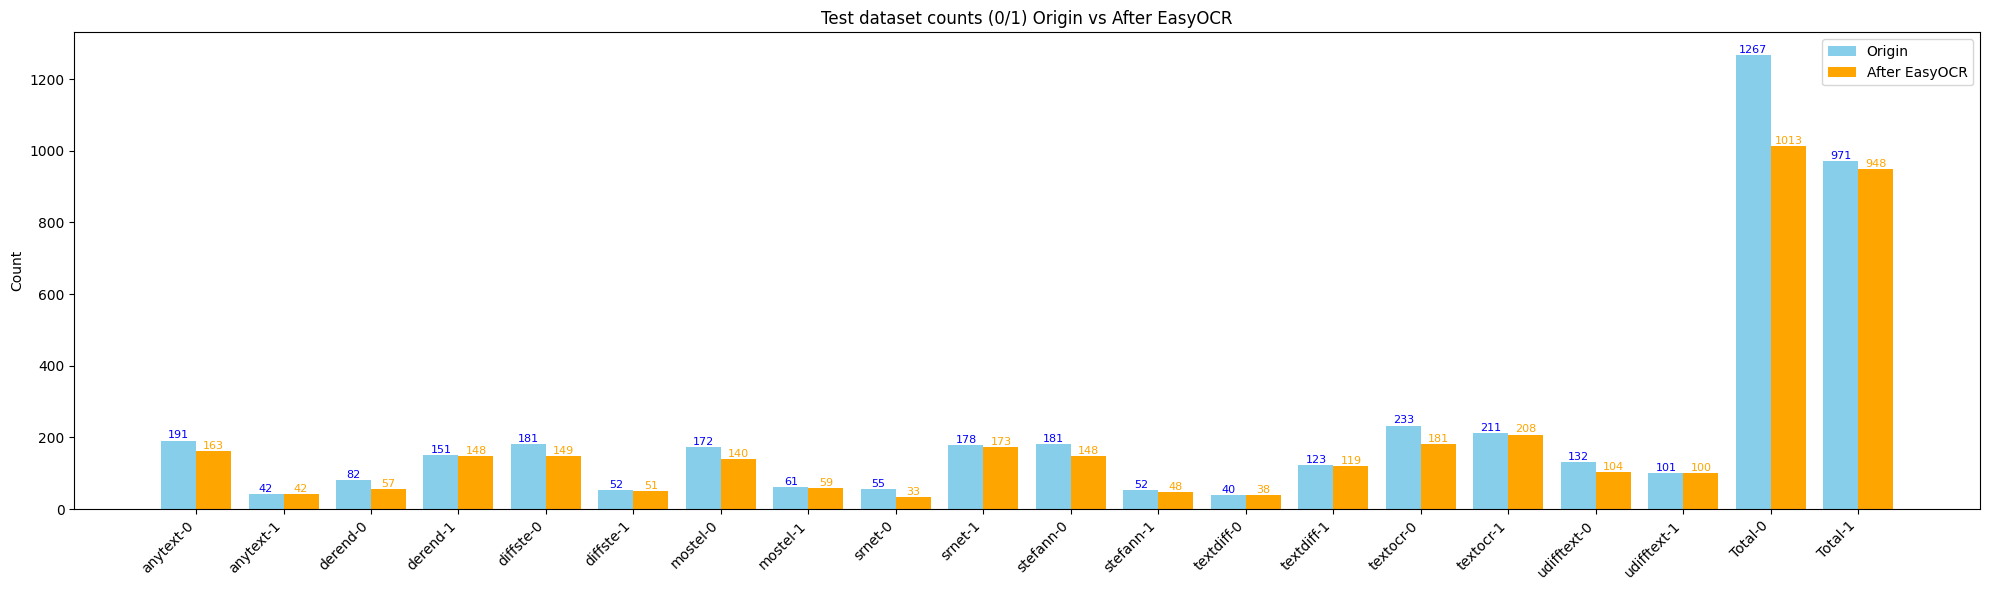

In [4]:
import os, pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ===== Paths =====
pks_dir = "./OSTF/pks"
pk_files = [
    "anytext_test.pk", "anytext_train.pk",
    "derend_test.pk", "derend_train.pk",
    "diffste_test.pk", "diffste_train.pk",
    "mostel_test.pk", "mostel_train.pk",
    "srnet_test.pk", "srnet_train.pk",
    "stefann_test.pk", "stefann_train.pk",
    "textdiff_test.pk", "textdiff_train.pk",
    "textocr_test.pk", "textocr_train.pk",
    "udifftext_test.pk", "udifftext_train.pk",
]

train_csv_path = "./OSTF/output/train.csv"
test_csv_path  = "./OSTF/output/test.csv"

def extract_category(txt_path: str) -> str:
    part = txt_path.split("txt/")[-1]
    category = part.split("/")[0]
    return category.replace("_train","").replace("_test","")

# collect PK labels
train_labels_pk_by_ds = defaultdict(list)
test_labels_pk_by_ds  = defaultdict(list)
for pk in pk_files:
    fpath = os.path.join(pks_dir, pk)
    if not os.path.exists(fpath):
        continue
    ds_name = pk.split("_")[0]
    split_type = "train" if "_train" in pk else "test"
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    for info in data.values():
        boxes = info.get("b", [])
        labels = [b[4] for b in boxes]
        img_label = 1 if any(l == 1 for l in labels) else 0
        if split_type == "train":
            train_labels_pk_by_ds[ds_name].append(img_label)
        else:
            test_labels_pk_by_ds[ds_name].append(img_label)

def collect_csv_labels(csv_path):
    label_dict = defaultdict(list)
    if not os.path.exists(csv_path):
        return label_dict
    df = pd.read_csv(csv_path)
    if "txt_path" not in df.columns or "label" not in df.columns:
        return label_dict
    df["category"] = df["txt_path"].apply(extract_category)
    for _, row in df.iterrows():
        label_dict[row["category"]].append(row["label"])
    return label_dict

train_labels_csv_by_ds = collect_csv_labels(train_csv_path)
test_labels_csv_by_ds  = collect_csv_labels(test_csv_path)

def plot_comparison_counts(pk_dict, csv_dict, title):
    ds_names = sorted(set(pk_dict.keys()) | set(csv_dict.keys()))
    x_labels = []
    pk_counts = []
    csv_counts = []
    for ds in ds_names:
        pk_count = Counter(pk_dict.get(ds, []))
        csv_count = Counter(csv_dict.get(ds, []))
        pk_counts.extend([pk_count.get(0,0), pk_count.get(1,0)])
        csv_counts.extend([csv_count.get(0,0), csv_count.get(1,0)])
        x_labels.extend([f"{ds}-0", f"{ds}-1"])
    # 전체 합계
    total_pk_0 = sum(pk_counts[::2]); total_pk_1 = sum(pk_counts[1::2])
    total_csv_0 = sum(csv_counts[::2]); total_csv_1 = sum(csv_counts[1::2])
    pk_counts.extend([total_pk_0, total_pk_1])
    csv_counts.extend([total_csv_0, total_csv_1])
    x_labels.extend(["Total-0","Total-1"])

    x = range(len(x_labels))
    bar_width = 0.4
    plt.figure(figsize=(max(10, len(x_labels)), 6))
    bars_pk = plt.bar([i-bar_width/2 for i in x], pk_counts, width=bar_width, color='skyblue', label='Origin')
    bars_csv = plt.bar([i+bar_width/2 for i in x], csv_counts, width=bar_width, color='orange', label='After EasyOCR')

    # annotate
    for i, bar in enumerate(bars_pk):
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                 f"{int(pk_counts[i])}", ha='center', va='bottom', fontsize=8, color='blue')
    for i, bar in enumerate(bars_csv):
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                 f"{int(csv_counts[i])}", ha='center', va='bottom', fontsize=8, color='orange')

    plt.xticks(x, x_labels, rotation=45, ha='right')
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run
plot_comparison_counts(train_labels_pk_by_ds, train_labels_csv_by_ds,
                       "Train dataset counts (0/1) Origin vs After EasyOCR")
plot_comparison_counts(test_labels_pk_by_ds, test_labels_csv_by_ds,
                       "Test dataset counts (0/1) Origin vs After EasyOCR")